In [47]:
import pickle
X_ppg,X_qual,X_acc,y_rr, y_respiration,y_inspiration,y_expiration,groups = pickle.load(open('../../affect-recognition/data/tabular_data.p','rb'))
X_ppg = X_ppg.reshape(-1,512,1)
y_rr = 60000/(1000*y_rr)

In [48]:
from keras.layers import Input, LSTM, RepeatVector,Bidirectional,Multiply,multiply,Permute
from keras.layers import TimeDistributed,Dense,Flatten,Reshape,Lambda,Activation,GRU
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import keras.backend as K
from keras import metrics,losses
import tensorflow as tf
import tensorflow_probability as tf
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=len(np.unique(groups)))
train,test = list(gkf.split(X_ppg,groups=groups))[1]
X_ppg_train,X_ppg_test = X_ppg[train],X_ppg[test]
X_qual_train,X_qual_test = X_qual[train],X_qual[test]
y_rr_train,y_rr_test = y_rr[train],y_rr[test]

In [49]:
def get_base_GRU(timesteps_ppg=512,input_dim_ppg=1,first_dim=60,optimizer='adam',loss='mae'):
    inputs = Input(shape=(timesteps_ppg, input_dim_ppg))
    encoded = Bidirectional(GRU(first_dim,return_sequences=True,activation='relu',go_backwards=True))(inputs)
    dense_layer = TimeDistributed(Dense(1,activation='relu'))(encoded)
    flattened = Flatten()(dense_layer)
    output = Dense(30,activation='relu')(flattened)
    output = Dense(1,activation='relu')(output)
    sequence_autoencoder = Model(inputs=[inputs], outputs=[output])
    sequence_autoencoder.compile(optimizer=optimizer,loss=loss)
    return sequence_autoencoder


timesteps_ppg = 512
input_dim_ppg = 1
sequence_autoencoder = get_base_GRU(timesteps_ppg=timesteps_ppg,input_dim_ppg=input_dim_ppg,
                                    first_dim=60,optimizer='adam',loss='mae')
sequence_autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 512, 120)          22320     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 512, 1)            121       
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 30)                15390     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 31        
Total params: 37,862
Trainable params: 37,862
Non-trainable params: 0
_______________________________________________________

In [50]:
history = sequence_autoencoder.fit(X_ppg_train, y_rr_train,
                epochs=50,
                batch_size=500,
                shuffle=True,
                validation_split=.2)

Train on 8024 samples, validate on 2006 samples
Epoch 1/50
8024/8024 [==============================] - 26s 3ms/step - loss: 49.7106 - val_loss: 22.2525
Epoch 2/50
8024/8024 [==============================] - 26s 3ms/step - loss: 23.1838 - val_loss: 16.1751
Epoch 3/50
8024/8024 [==============================] - 26s 3ms/step - loss: 17.6403 - val_loss: 12.8503
Epoch 4/50
8024/8024 [==============================] - 25s 3ms/step - loss: 15.5440 - val_loss: 11.1112
Epoch 5/50
8024/8024 [==============================] - 26s 3ms/step - loss: 13.7802 - val_loss: 10.8584
Epoch 6/50
8024/8024 [==============================] - 26s 3ms/step - loss: 12.5276 - val_loss: 11.0936
Epoch 7/50
8024/8024 [==============================] - 26s 3ms/step - loss: 11.7718 - val_loss: 9.4138
Epoch 8/50
8024/8024 [==============================] - 26s 3ms/step - loss: 10.8729 - val_loss: 9.4014
Epoch 9/50
8024/8024 [==============================] - 26s 3ms/step - loss: 10.1603 - val_loss: 8.8262
Epoch 10/5

In [51]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [52]:
y_rr_pred = sequence_autoencoder.predict(X_ppg_test)

<IPython.core.display.Javascript object>


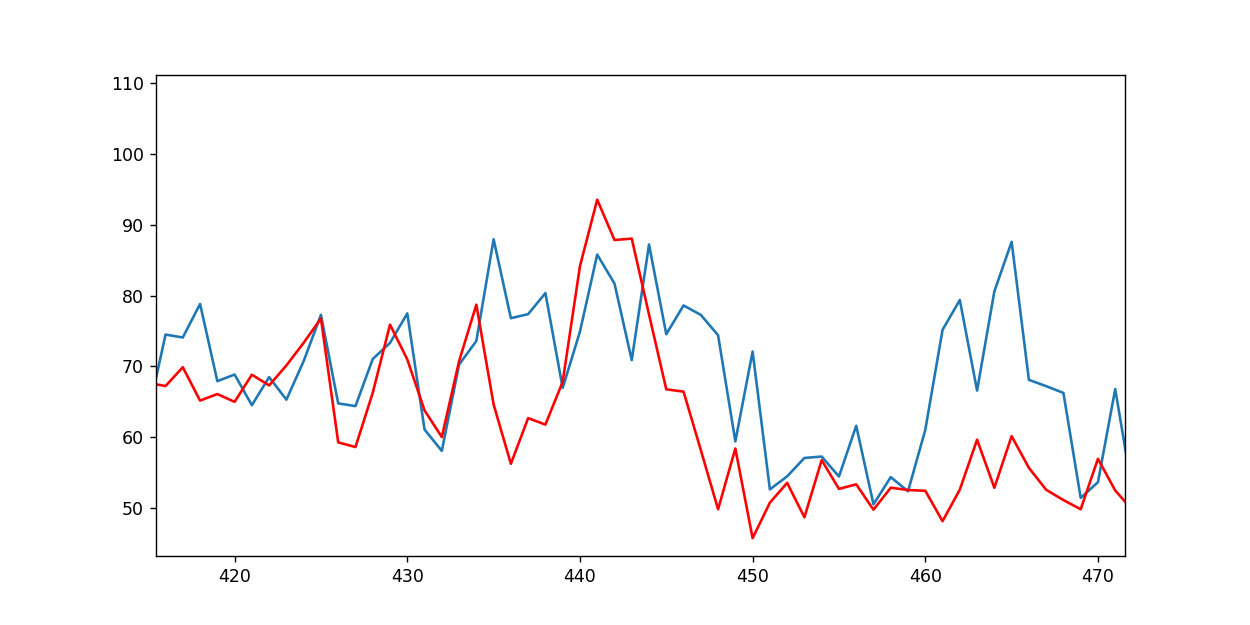

In [53]:
plt.figure(figsize=(10,5))
plt.plot(y_rr_pred)
plt.plot(y_rr_test,'r')

In [54]:
differences = np.abs(y_rr_pred-y_rr_test)

In [55]:
relative_powers = [np.mean(a[:,-1]) for a in X_qual_test]

In [57]:
plt.figure(fig)
plt.scatter(relative_powers,differences)
plt.show()